In [1]:
%matplotlib inline

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
import seir_func_point as seir_func
import map_functions
import arviz as az
import theano
import pickle

plt.style.use('seaborn-darkgrid')

In [2]:
city = "rj"
time_stamp = int(1.5 * 365)
incidence_real = map_functions.get_cases(city=city)[1:time_stamp]
infected_percentage = incidence_real[0]/map_functions.pop_dict[city]

In [3]:
seir = seir_func.seir()

In [4]:
seir_model = DifferentialEquation(
    func=seir.derivate,
    times=np.arange(1, time_stamp, 1),
    n_states=10,
    n_theta=16,
    t0=0,
)

In [6]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    SH = pm.Uniform("SH", 0, 1, testval = 0.4891611167313461,)
    IH = infected_percentage
    EH = infected_percentage
    RH = 1 - SH - 2 * infected_percentage
    
    
    a_t = pm.Uniform("$a(t)$", 0.5, 2, testval = 0.691410701905391)
    p_mh_t = pm.Uniform("$p_mh(t)$", 0.5, 2, testval = 1.5609791900930738)
    u_v = pm.Uniform("$u_v$", 0.5, 2, testval = 1.1218292459714525)
    k = pm.Uniform("$k$", 0.5, 2, testval = 1.0323746614550986)
    gamma = pm.Uniform("$\gamma$", 0.5, 2, testval = 0.5232776467454814)
    delta = pm.Uniform("$\delta$", 0.5, 2, testval = 0.9923266319695812)
    

    sir_curves = seir_model(y0=[
        1000, 0, 0.99, 0, 0.0, 
        SH, IH, EH, 
        RH, IH
    ], 
                           theta=[1, 1, a_t, 
                  1, p_mh_t, 
                  1, 1, u_v, 
                  1, 1, 1, k, 
                  1, gamma, 
                  delta, 1]
                           )

    incidence = pm.Gamma('incidence', 
                     mu=sir_curves[:,9], 
                     sigma=sigma, 
                     observed=incidence_real)
    
    
    # db = pm.backends.Text('database/traces.csv') # Salva as amostras e assim evita de manter tudo na memória
    # old_trace = pm.load_trace('mcmc.trace', model=model4) 
    advi = pm.ADVI()
    
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  # callable that returns mean
        std=advi.approx.std.eval,  # callable that returns std
    )
    
    approx = pm.fit(method="advi", n = 1500, callbacks=[tracker])
    # trace = pm.sample(200, tune=0, cores=3, chains=1, trace=old_trace)
    with open('approx-2.p', 'wb') as f:
        pickle.dump(approx, f)
    # pm.save_trace(trace, 'mcmc.trace', overwrite=True) 

Finished [100%]: Average Loss = 15,952


In [5]:
with open('approx-2.p', 'rb') as f:
    approx = pickle.load(f)

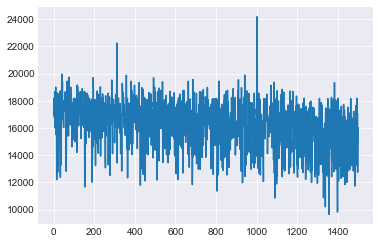

In [6]:
plt.plot(approx.hist)

Text(0.5, 1.0, 'Negative ELBO track')

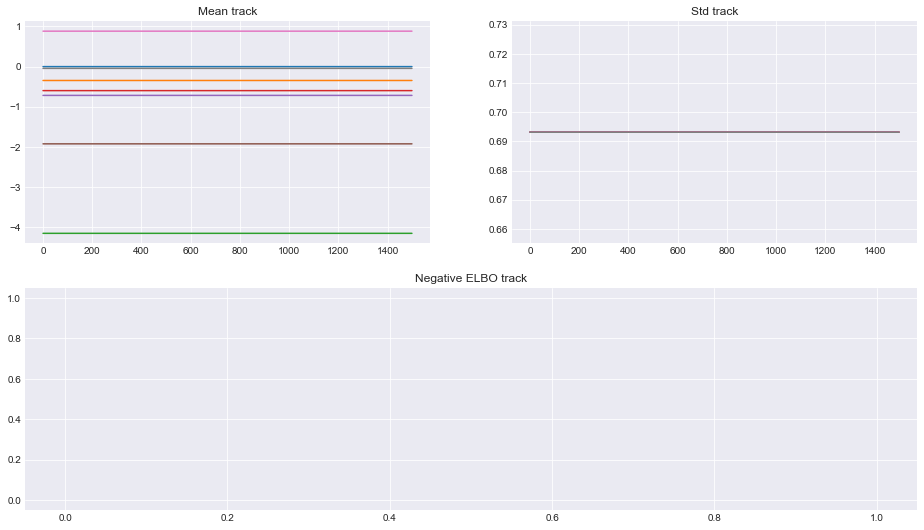

In [9]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track")

In [7]:
trace = approx.sample(draws=400)

In [ ]:
#inference    
pm.plots.traceplot(trace);    
pm.plot_posterior(trace, color='LightSeaGreen');

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [14]:
trace.points

<bound method MultiTrace.points of <MultiTrace: 1 chains, 215 iterations, 16 variables>>

In [15]:
data = az.from_pymc3(trace=trace)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f145f44d240>,
      dtype=object)

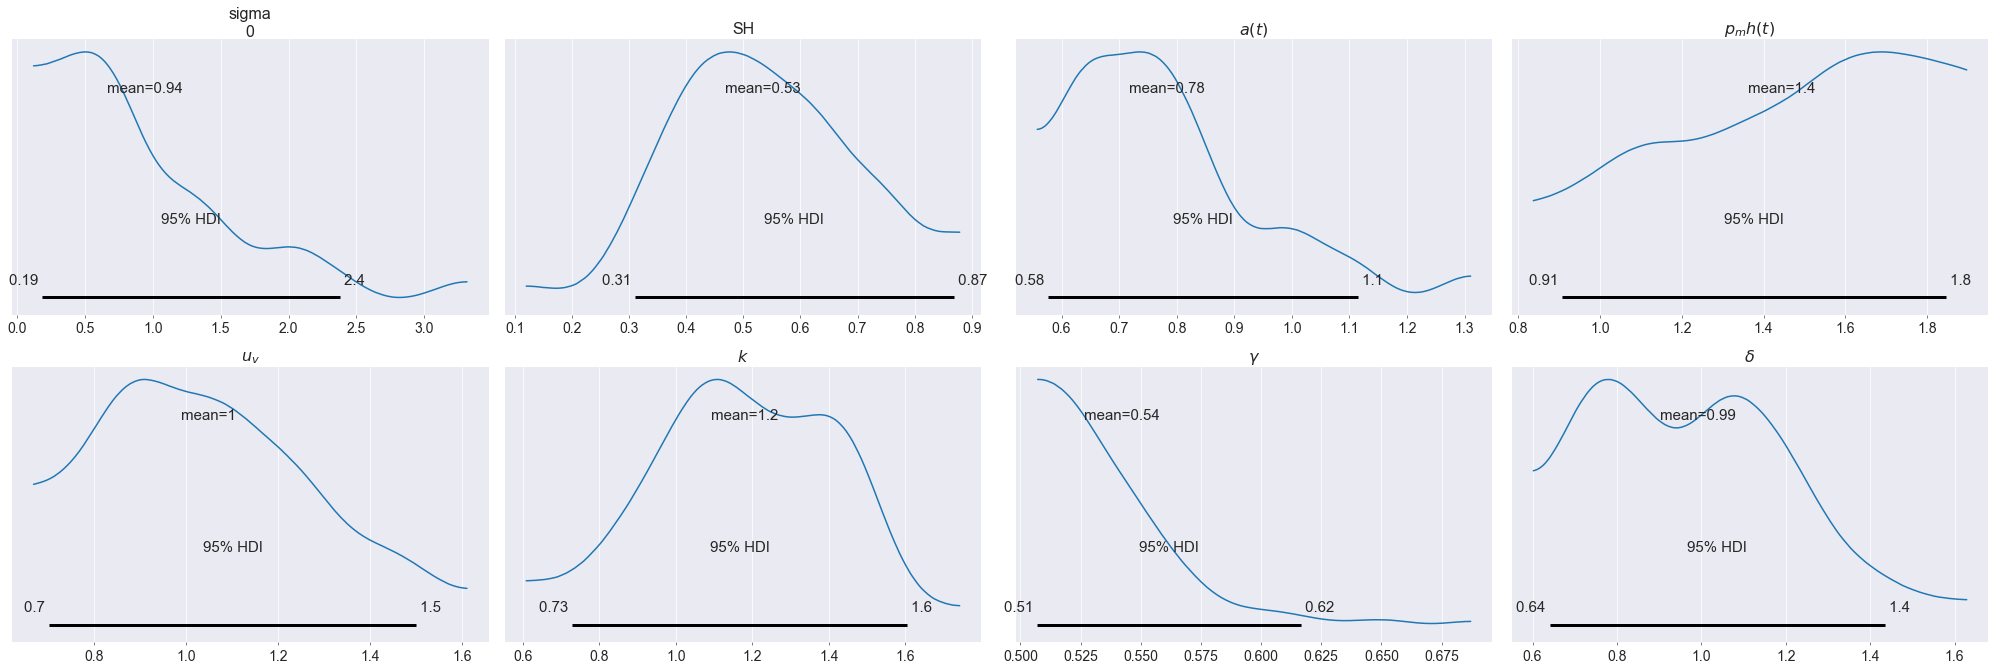

In [16]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95)